# to do:
# - mosquito lift span
# - mosquito activity range
# - mosquito species
# - location - one hot coding?


## background


https://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health/





The common house mosquito, Culex pipiens (Diptera: Culicidae), which is considered the primary bridge vector of West Nile Virus (WNV) to humans, is a wide spread insect pest with medical importance and consists of two distinct bioforms, Cx. pipiens f. pipiens and Cx. pipiens f. molestus. Here, we consider the adult lifespan of male and female Cx. pipiens f. pipiens under controlled conditions at five constant temperature regimes (15, 20, 25, 27.5, and 30 °C). Our results show that adult longevity was affected by temperature, as it significantly decreased with increase in temperature. At the highest tested temperature, mean adult longevity did not exceed 12 days for both sexes and thus makes impossible the risk of WNV transmission. On the other hand at the lowest temperature, longevity was extremely high with some individuals surviving up to 129 and 132 days, males and females, respectively, and thus enable them to function as potential vectors of WNV for a prolonged period of time. As far as sex is concerned, adult females displayed a 1.2–1.4-fold longer longevity compared to the male ones. However, this difference was significant only at the lowest and highest tested temperature regime. This information is useful in determining the critical temperatures which may affect the distribution of Cx. pipiens and consequently the risk of WNV transmission. Moreover, the effect of environmental temperature should be considered when evaluating the abundance of these species.
https://link.springer.com/article/10.1007/s00436-014-4152-x



# Import Libraries

In [229]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
from sklearn.inspection import partial_dependence,PartialDependenceDisplay

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm


import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import geopandas as gpd
import contextily as cx

plt.ion()

In [230]:
#steps to install geopandas


#pip install pipwin
#!pipwin install gdal
#!pipwin install fiona
#pip install geopandas
#!pipwin install rasterio
#pip install contextily

# define some functions

In [231]:
#the
def plot_geodata(dict_df):
    colors = ['black','red','orange','yellow']
    markersizes = [3, 14, 1, 5]
    zorders = [4,3,1,2]
    
    fig_, ax_ = plt.subplots(figsize=(20,20))
    
    #plot community
    geojson_file = '../input/Boundaries_Community_Areas.geojson'
    neighborhoods = gpd.read_file(geojson_file)
    neighborhoods.plot(ax=ax_)
    
    #plot station
    # initialize list of lists
    list_station = [['1',  41.995,-87.933], ['2', 41.786,-87.752]]
    # Create the pandas DataFrame
    df_station = pd.DataFrame(list_station, columns=['Station', 'Latitude','Longitude'])
    gdf = gpd.GeoDataFrame(df_station, geometry=gpd.points_from_xy(df_station.Longitude, df_station.Latitude))
    gdf.plot(ax=ax_, color='purple', markersize=20,zorder=5, label="weather stations")
    
    i=0
    for label_df,df in dict_df.items():
        color_ = colors[i]
        markersize_ = markersizes[i]
        zorder_ = zorders[i]
        label_ = label_df

        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.plot(ax=ax_, color=color_, markersize=markersize_,zorder=zorder_, label=label_)
        i += 1
        
    ax_.legend(loc='lower left', fontsize=12, markerscale=5)
    plt.show()
    return 

#the
def plot_geodata(df, fig_=None, ax_=None, color_='red', markersize_=1 ,zorder_=2, label_=None):
    if fig_ == None:
        fig_, ax_ = plt.subplots(figsize=(20,20))
        geojson_file = '../input/Boundaries_Community_Areas.geojson'
        neighborhoods = gpd.read_file(geojson_file)
        neighborhoods.plot(ax=ax_)
        
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    gdf.plot(ax=ax_, color=color_, markersize=markersize_,zorder=zorder_, label=label_)
    ax_.legend(loc='lower left', fontsize=12, markerscale=5)
    #plt.show()
    fig
    return fig_, ax_

# impot data

In [232]:
df_train = pd.read_csv("../input/train.csv")

In [233]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.99,-87.77,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,4,0


In [234]:
df_train.groupby('Species').count()

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Species,,,,,,,,,,,
CULEX ERRATICUS,1,1,1,1,1,1,1,1,1,1,1
CULEX PIPIENS,2699,2699,2699,2699,2699,2699,2699,2699,2699,2699,2699
CULEX PIPIENS/RESTUANS,4752,4752,4752,4752,4752,4752,4752,4752,4752,4752,4752
CULEX RESTUANS,2740,2740,2740,2740,2740,2740,2740,2740,2740,2740,2740
CULEX SALINARIUS,86,86,86,86,86,86,86,86,86,86,86
CULEX TARSALIS,6,6,6,6,6,6,6,6,6,6,6
CULEX TERRITANS,222,222,222,222,222,222,222,222,222,222,222


In [235]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Block,"10,506.00",35.69,24.34,10.00,12.00,33.00,52.00,98.00
Latitude,"10,506.00",41.84,0.11,41.64,41.73,41.85,41.95,42.02
Longitude,"10,506.00",-87.70,0.10,-87.93,-87.76,-87.69,-87.63,-87.53
AddressAccuracy,"10,506.00",7.82,1.45,3.00,8.00,8.00,9.00,9.00
NumMosquitos,"10,506.00",12.85,16.13,1.00,2.00,5.00,17.00,50.00
WnvPresent,"10,506.00",0.05,0.22,0.00,0.00,0.00,0.00,1.00


In [236]:
gdf_train = gpd.GeoDataFrame(df_train, geometry=gpd.points_from_xy(df_train.Longitude, df_train.Latitude))

In [237]:
# 3 - Neighbourhoods
geojson_file = '../input/Boundaries_Community_Areas.geojson'
neighborhoods = gpd.read_file(geojson_file)
neighborhoods.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


In [238]:
gdf_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,geometry
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0,POINT (-87.80099 41.95469)
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0,POINT (-87.80099 41.95469)
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.99,-87.77,9,1,0,POINT (-87.76928 41.99499)
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,1,0,POINT (-87.82481 41.97409)
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,4,0,POINT (-87.82481 41.97409)


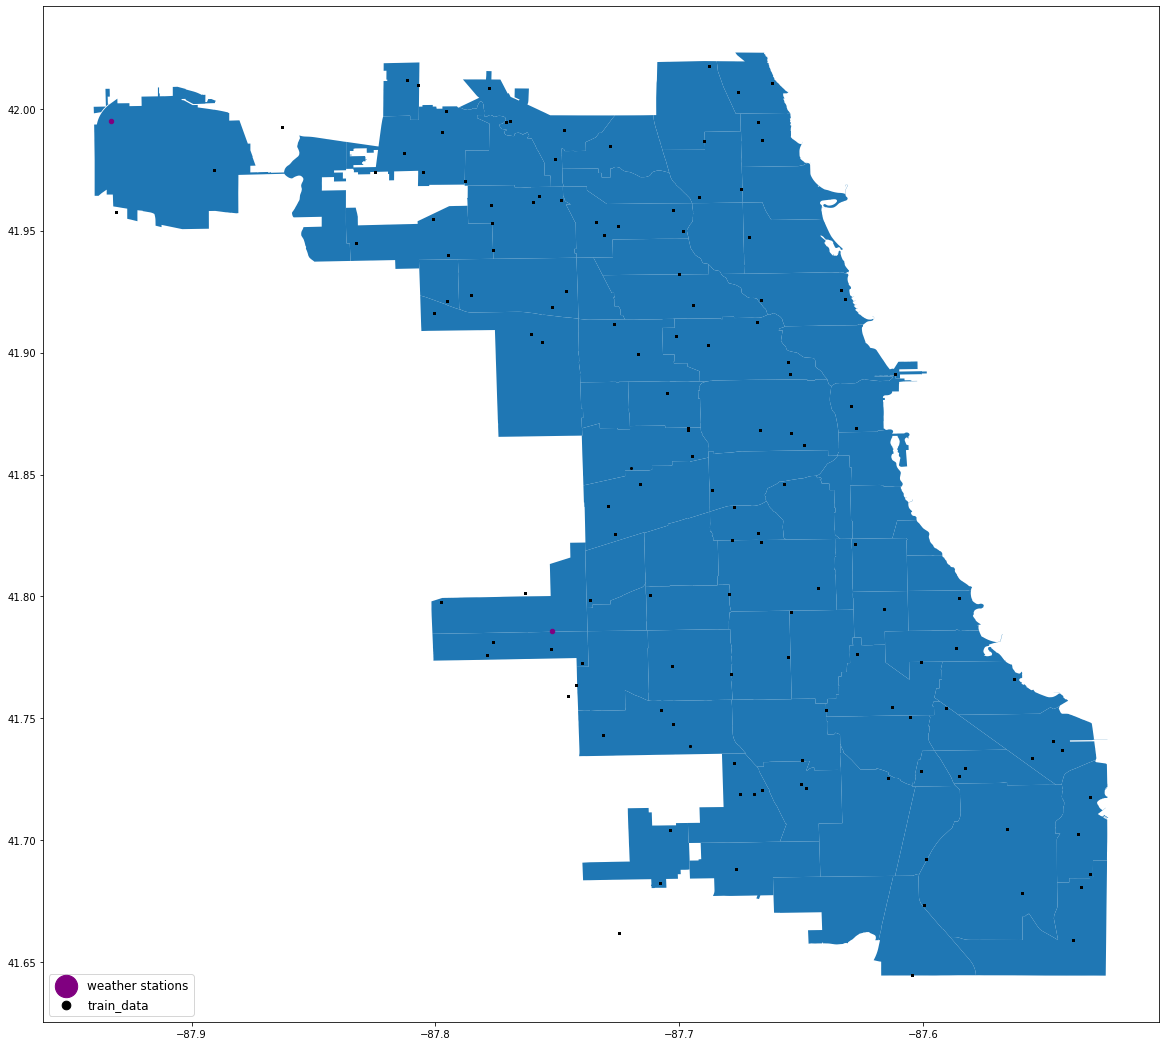

In [239]:
dict_df = {'train_data':df_train           
          }
plot_geodata(dict_df)

gdf_train_wm = gdf_train.set_crs(epsg=3857)

ax = gdf_train_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, crs=)



#### test data

In [240]:
df_test = pd.read_csv("../input/test.csv")
df_test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9


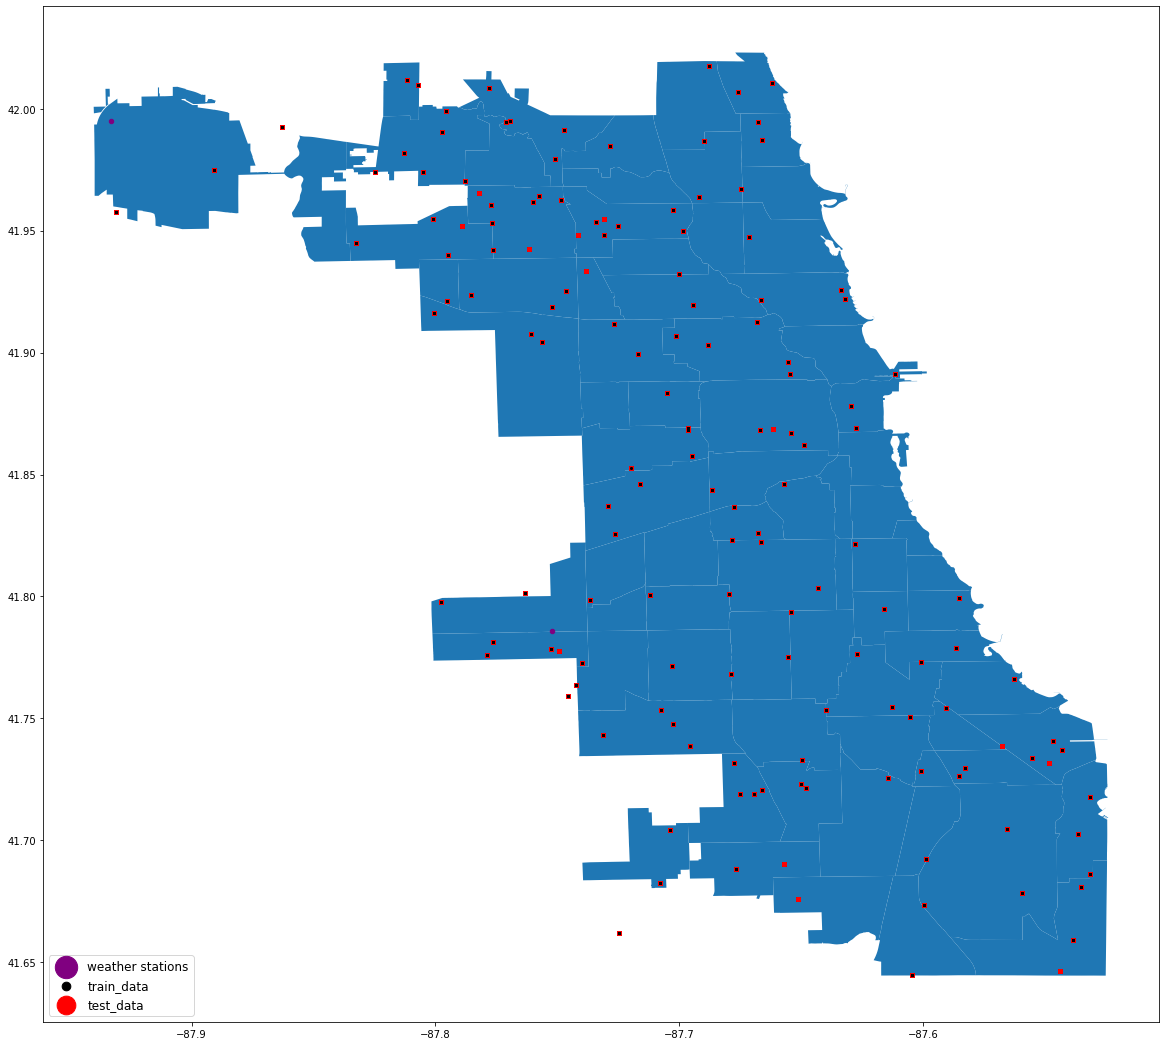

In [241]:
dict_df = {'train_data':df_train, 
           'test_data':df_test,
          }
plot_geodata(dict_df)


#### spray data

In [242]:
df_spray = pd.read_csv("../input/spray.csv")
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.39,-88.09
1,2011-08-29,6:57:08 PM,42.39,-88.09
2,2011-08-29,6:57:18 PM,42.39,-88.09
3,2011-08-29,6:57:28 PM,42.39,-88.09
4,2011-08-29,6:57:38 PM,42.39,-88.09


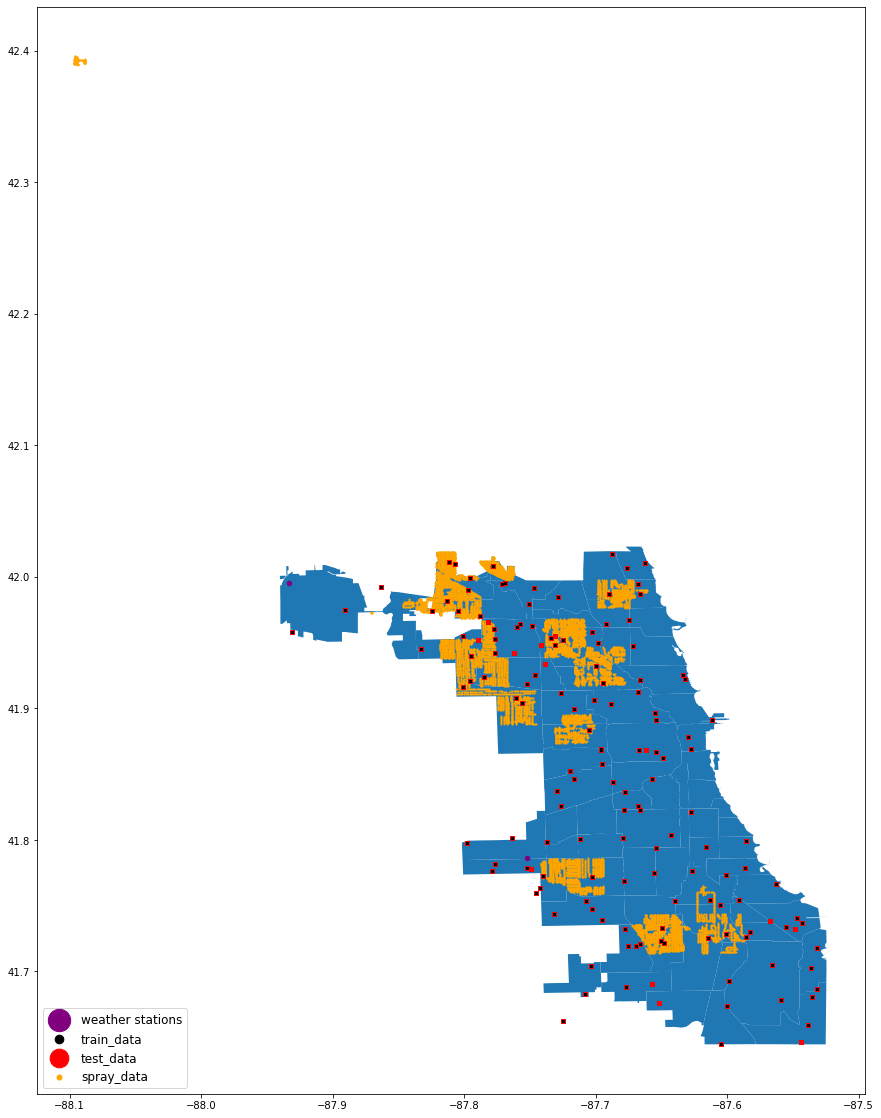

In [243]:
dict_df = {'train_data':df_train, 
           'test_data':df_test,
           'spray_data':df_spray,
           
          }
plot_geodata(dict_df)


In [244]:
df_spray = df_spray.query("Latitude < 42.3")

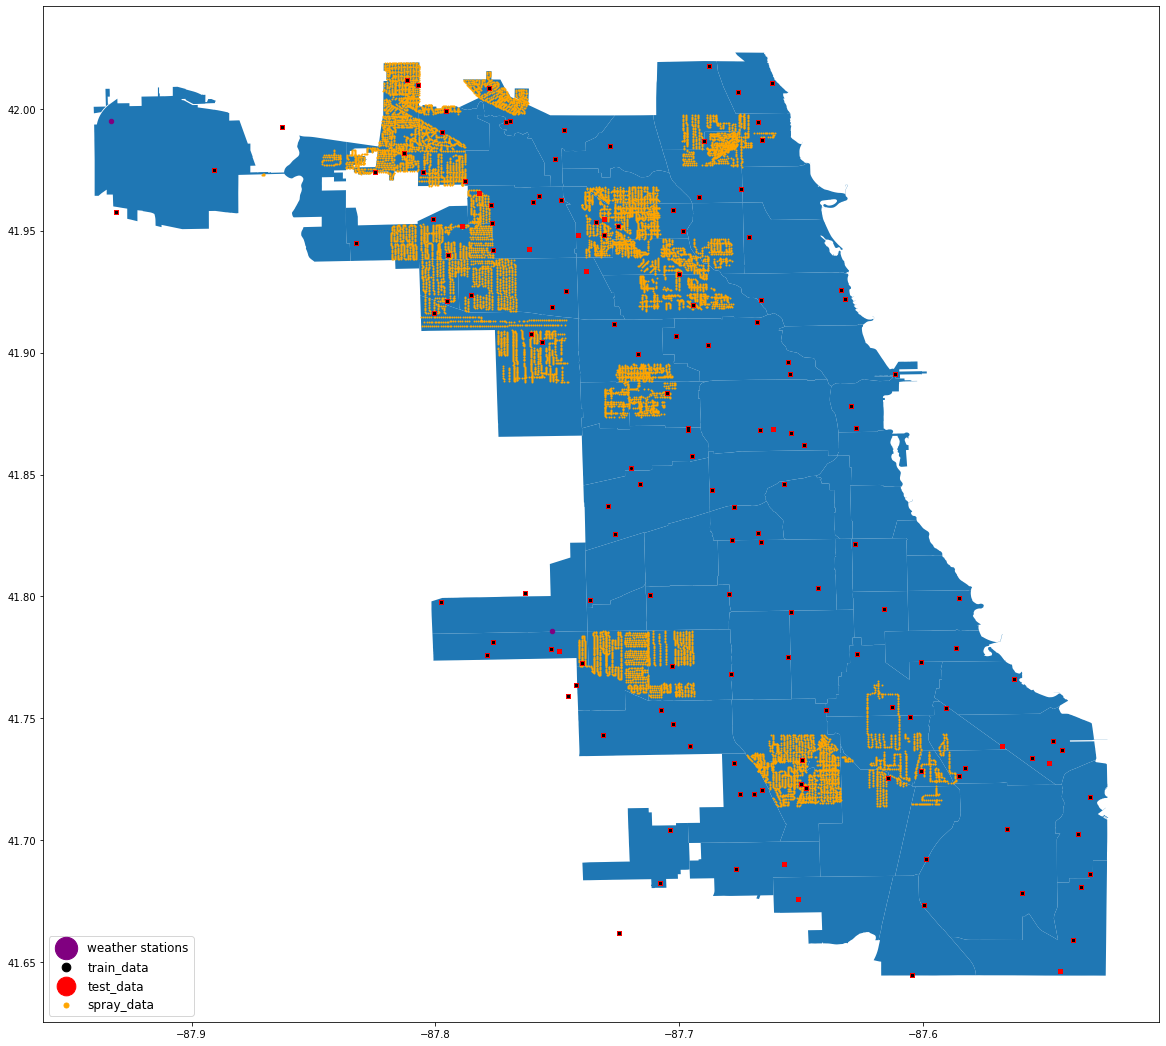

In [245]:
dict_df = {'train_data':df_train, 
           'test_data':df_test,
           'spray_data':df_spray,
           
          }
plot_geodata(dict_df)


#### weather data

In [246]:
df_weather = pd.read_csv("../input/weather.csv")
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.70,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.70,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.00,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.30,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.70,7,11.9


# initialize list of lists
list_station = [['1',  41.995,-87.933], ['2', 41.786,-87.752]]
# Create the pandas DataFrame
df_station = pd.DataFrame(list_station, columns=['Station', 'Latitude','Longitude'])

df_weather['Latitude'] = np.where(df_weather['Station'] == 1, 41.995,41.786 )
df_weather['Longitude'] = np.where(df_weather['Station'] == 1, -87.933,-87.752 )


dict_df = {'train_data':df_train, 
           'test_data':df_test,
           'spray_data':df_spray,
           'weather_station':df_station
           
           
          }
plot_geodata(dict_df)

## data cleaning

**df_train**

In [247]:
df_train.isnull().sum().sort_values(ascending=False)

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
geometry                  0
dtype: int64

In [248]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Date                    10506 non-null  object  
 1   Address                 10506 non-null  object  
 2   Species                 10506 non-null  object  
 3   Block                   10506 non-null  int64   
 4   Street                  10506 non-null  object  
 5   Trap                    10506 non-null  object  
 6   AddressNumberAndStreet  10506 non-null  object  
 7   Latitude                10506 non-null  float64 
 8   Longitude               10506 non-null  float64 
 9   AddressAccuracy         10506 non-null  int64   
 10  NumMosquitos            10506 non-null  int64   
 11  WnvPresent              10506 non-null  int64   
 12  geometry                10506 non-null  geometry
dtypes: float64(2), geometry(1), int64(4), object(6)
memory usage: 1.0+ MB


In [249]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  geometry                10506 non-null  geomet

**clean df_test**

In [250]:
df_test.isnull().sum().sort_values(ascending=False)

Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
geometry                  0
dtype: int64

In [251]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   Id                      116293 non-null  int64   
 1   Date                    116293 non-null  object  
 2   Address                 116293 non-null  object  
 3   Species                 116293 non-null  object  
 4   Block                   116293 non-null  int64   
 5   Street                  116293 non-null  object  
 6   Trap                    116293 non-null  object  
 7   AddressNumberAndStreet  116293 non-null  object  
 8   Latitude                116293 non-null  float64 
 9   Longitude               116293 non-null  float64 
 10  AddressAccuracy         116293 non-null  int64   
 11  geometry                116293 non-null  geometry
dtypes: float64(2), geometry(1), int64(3), object(6)
memory usage: 10.6+ MB


In [252]:
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
 11  geometry                116293 non-null  geometry      
dtypes: datetime64[ns](1), float64(

**clean df_spray**

In [253]:
df_spray.isnull().sum().sort_values(ascending=False)

Time         584
Date           0
Latitude       0
Longitude      0
geometry       0
dtype: int64

In [254]:
df_spray.shape

(14740, 5)

In [255]:
df_spray.head(20)

,Date,Time,Latitude,Longitude,geometry
95,2011-09-07,7:52:52 PM,41.98,-87.79,POINT (-87.78778 41.98143)
96,2011-09-07,7:53:02 PM,41.98,-87.79,POINT (-87.78778 41.98100)
97,2011-09-07,7:53:12 PM,41.98,-87.79,POINT (-87.78776 41.98056)
98,2011-09-07,7:53:22 PM,41.98,-87.79,POINT (-87.78776 41.98020)
99,2011-09-07,7:53:32 PM,41.98,-87.79,POINT (-87.78776 41.97975)
100,2011-09-07,7:53:42 PM,41.98,-87.79,POINT (-87.78775 41.97935)
101,2011-09-07,7:53:52 PM,41.98,-87.79,POINT (-87.78776 41.97885)
102,2011-09-07,7:54:02 PM,41.98,-87.79,POINT (-87.78777 41.97840)
103,2011-09-07,7:54:12 PM,41.98,-87.79,POINT (-87.78776 41.97799)
104,2011-09-07,7:54:22 PM,41.98,-87.79,POINT (-87.78778 41.97749)


In [256]:
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14740 entries, 95 to 14834
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Date       14740 non-null  object  
 1   Time       14156 non-null  object  
 2   Latitude   14740 non-null  float64 
 3   Longitude  14740 non-null  float64 
 4   geometry   14740 non-null  geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 690.9+ KB


In [257]:
df_spray['Date']=pd.to_datetime(df_spray['Date'])
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14740 entries, 95 to 14834
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14740 non-null  datetime64[ns]
 1   Time       14156 non-null  object        
 2   Latitude   14740 non-null  float64       
 3   Longitude  14740 non-null  float64       
 4   geometry   14740 non-null  geometry      
dtypes: datetime64[ns](1), float64(2), geometry(1), object(1)
memory usage: 690.9+ KB


**clean df_weather**

In [258]:
df_weather.isnull().sum().sort_values(ascending=False)

Station        0
Date           0
ResultDir      0
ResultSpeed    0
SeaLevel       0
StnPressure    0
PrecipTotal    0
SnowFall       0
Water1         0
Depth          0
CodeSum        0
Sunset         0
Sunrise        0
Cool           0
Heat           0
WetBulb        0
DewPoint       0
Depart         0
Tavg           0
Tmin           0
Tmax           0
AvgSpeed       0
dtype: int64

In [259]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [260]:
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [261]:
df_weather['Tavg'].value_counts()

73    138
77    117
70    117
75    110
71    109
74    107
72    104
69    103
78    102
76    100
68     99
79     98
66     93
67     89
61     88
64     86
80     84
65     84
63     81
57     67
62     66
60     61
50     57
81     55
53     49
58     49
54     48
82     48
55     48
56     46
52     46
59     45
51     36
83     34
49     29
45     28
47     24
46     24
84     21
44     19
48     17
85     16
86     16
42     15
43     12
M      11
87      9
41      7
40      5
39      4
89      4
88      4
91      4
37      2
38      2
90      2
36      2
92      1
93      1
94      1
Name: Tavg, dtype: int64

In [262]:
df_weather.query("Tavg == 'M'")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.10,7,10.4
505,2,2008-07-08,86,46,M,M,68,71,M,M,-,-,TS RA,M,M,M,0.28,29.16,29.80,7.40,24,8.3
675,2,2008-10-01,62,46,M,M,41,47,M,M,-,-,,M,M,M,0.00,29.30,29.96,10.90,33,11.0
1637,2,2011-07-22,100,71,M,M,70,74,M,M,-,-,TS TSRA BR,M,M,M,0.14,29.23,29.86,3.80,10,8.2
2067,2,2012-08-22,84,72,M,M,51,61,M,M,-,-,,M,M,M,0.00,29.39,M,4.70,19,M
2211,2,2013-05-02,71,42,M,M,39,45,M,M,-,-,,M,M,M,0.00,29.51,30.17,15.80,2,16.1
2501,2,2013-09-24,91,52,M,M,48,54,M,M,-,-,,M,M,M,0.00,29.33,30.00,5.80,9,7.7
2511,2,2013-09-29,84,53,M,M,48,54,M,M,-,-,RA BR,M,M,M,0.22,29.36,30.01,6.30,36,7.8
2525,2,2013-10-06,76,48,M,M,44,50,M,M,-,-,RA DZ BR,M,M,M,0.06,29.10,29.76,10.10,25,10.6
2579,2,2014-05-02,80,47,M,M,43,47,M,M,-,-,RA,M,M,M,0.04,29.10,29.79,10.70,23,11.9


In [263]:
df_weather['Tavg']=np.where(df_weather['Tavg']=='M', (df_weather['Tmax']+df_weather['Tmin'])/2, df_weather['Tavg'])
df_weather['Tavg']=df_weather['Tavg'].astype(float)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [264]:
df_weather['Water1'].value_counts()

M    2944
Name: Water1, dtype: int64

In [265]:
df_weather['PrecipTotal'].value_counts()

0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
0.04      36
0.05      32
0.08      28
0.12      28
0.06      27
0.07      23
0.16      21
0.09      21
0.11      20
0.14      20
0.17      17
0.28      15
0.13      14
0.19      14
0.18      14
0.20      13
0.15      13
0.23      11
0.25      11
0.26      11
0.10      10
0.24      10
0.31       9
0.39       9
0.40       9
0.21       9
0.29       9
0.43       9
0.34       8
0.32       8
0.22       8
0.33       7
0.41       7
0.50       7
0.48       7
0.37       7
0.45       7
0.59       7
0.30       7
0.80       6
0.63       6
0.84       6
0.65       6
0.27       6
0.92       5
0.68       5
0.44       5
0.36       5
0.54       5
0.93       5
0.85       5
1.23       4
0.72       4
0.75       4
0.64       4
0.52       4
0.70       4
0.55       4
0.97       4
0.51       4
0.58       4
0.89       4
0.66       4
0.87       3
0.60       3
1.31       3
1.05       3
1.01       3
0.77       3
1.03       3
0.56       3
0.88       3

Special symbols

Symbols that appear on many of the individual summaries: (*) less than one half; (T ) trace, an amount too small to measure; (—) below zero temperatures are preceded by a minus sign.
Weather averages year-by-year

PRECIPITATION refers to the inches of water equivalent in the total of all forms of liquid or frozen precipitation that fell during each month. Snowfall refers to the actual amount of snow in inches that fell during the month. T (trace) is a precipitation amount of less than 0.005 in (note: in estimating the water equivalent of snow a ratio of 10 in of snow equal 1 in of water is customarily employed).
https://www.encyclopedia.com/environment/encyclopedias-almanacs-transcripts-and-maps/local-climatological-data-reports


In [266]:
df_weather['PrecipTotal']=np.where(df_weather['PrecipTotal'].str.strip() =='T', 0, df_weather['PrecipTotal'] )
df_weather['PrecipTotal']=np.where(df_weather['PrecipTotal'].str.strip() =='M', 0, df_weather['PrecipTotal'] )
df_weather['PrecipTotal']=df_weather['PrecipTotal'].astype(float)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

## compare species from df_train and df_test

In [267]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  geometry                10506 non-null  geomet

In [268]:
df_train['Species'].value_counts(normalize=True)

CULEX PIPIENS/RESTUANS   0.45
CULEX RESTUANS           0.26
CULEX PIPIENS            0.26
CULEX TERRITANS          0.02
CULEX SALINARIUS         0.01
CULEX TARSALIS           0.00
CULEX ERRATICUS          0.00
Name: Species, dtype: float64

In [269]:
df_test['Species'].value_counts(normalize=True)

CULEX PIPIENS/RESTUANS   0.13
CULEX RESTUANS           0.13
CULEX PIPIENS            0.12
CULEX SALINARIUS         0.12
CULEX TERRITANS          0.12
CULEX TARSALIS           0.12
UNSPECIFIED CULEX        0.12
CULEX ERRATICUS          0.12
Name: Species, dtype: float64

In [270]:
df_train['NumMosquitos'].value_counts(normalize=False)

1     2307
2     1300
50    1019
3      896
4      593
5      489
6      398
7      326
8      244
9      237
10     206
11     170
13     163
12     132
16     128
14     120
15     112
17     107
18      92
19      86
21      85
20      79
23      69
27      67
37      61
24      57
26      57
22      56
25      50
39      49
29      48
36      47
31      47
30      44
28      43
35      43
46      43
43      39
32      39
47      37
33      36
48      36
45      35
38      35
49      35
41      31
34      31
42      29
40      28
44      25
Name: NumMosquitos, dtype: int64

In [271]:
df_train['Trap'].value_counts(normalize=False)

T900     750
T115     542
T138     314
T002     185
T135     183
T054     163
T128     160
T151     156
T212     152
T090     151
T114     148
T158     147
T048     146
T031     146
T903     140
T008     139
T011     133
T209     130
T200     129
T073     128
T030     126
T003     122
T094     121
T028     117
T066     116
T074     115
T047     114
T221     112
T102     112
T009     111
T159     111
T046     110
T065     109
T012     105
T063     104
T013     104
T225     103
T061     103
T082      98
T147      98
T220      98
T033      97
T152      93
T027      93
T080      92
T145      91
T160      91
T089      91
T095      90
T223      87
T086      86
T155      86
T049      85
T103      83
T079      83
T069      83
T062      82
T039      80
T227      78
T017      78
T226      77
T144      74
T083      74
T218      74
T035      72
T148      69
T016      66
T230      65
T018      63
T043      63
T235      62
T228      62
T222      60
T224      54
T232      50
T096      50
T233      50

In [272]:
df_test['Trap'].value_counts(normalize=False)

T009     1528
T035     1520
T900     1468
T002      857
T008      822
T011      814
T027      803
T151      797
T054      792
T903      784
T028      783
T231      781
T012      781
T003      780
T220      776
T073      776
T115      776
T016      775
T223      774
T128      774
T063      774
T135      774
T158      773
T212      773
T114      772
T102      772
T030      771
T159      770
T013      769
T221      769
T082      769
T147      769
T090A     768
T138      768
T074      768
T218      767
T065A     767
T080      767
T047      767
T225      766
T200A     766
T233      765
T065      765
T144      765
T200      765
T089      765
T145      764
T228      764
T152      764
T048      763
T066      763
T076      763
T083      763
T031      763
T236      763
T090      763
T209      763
T218B     762
T227      762
T046      762
T069      762
T062      762
T061      762
T230      762
T095      762
T033      762
T218C     762
T014      762
T222      762
T045      762
T235      761
T148  

In [273]:
df_train_max_mosqui = df_train.query("NumMosquitos == 50")

In [274]:
df_train_max_mosqui['WnvPresent'].value_counts()

0    911
1    108
Name: WnvPresent, dtype: int64

In [275]:
df_train['WnvPresent'].value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

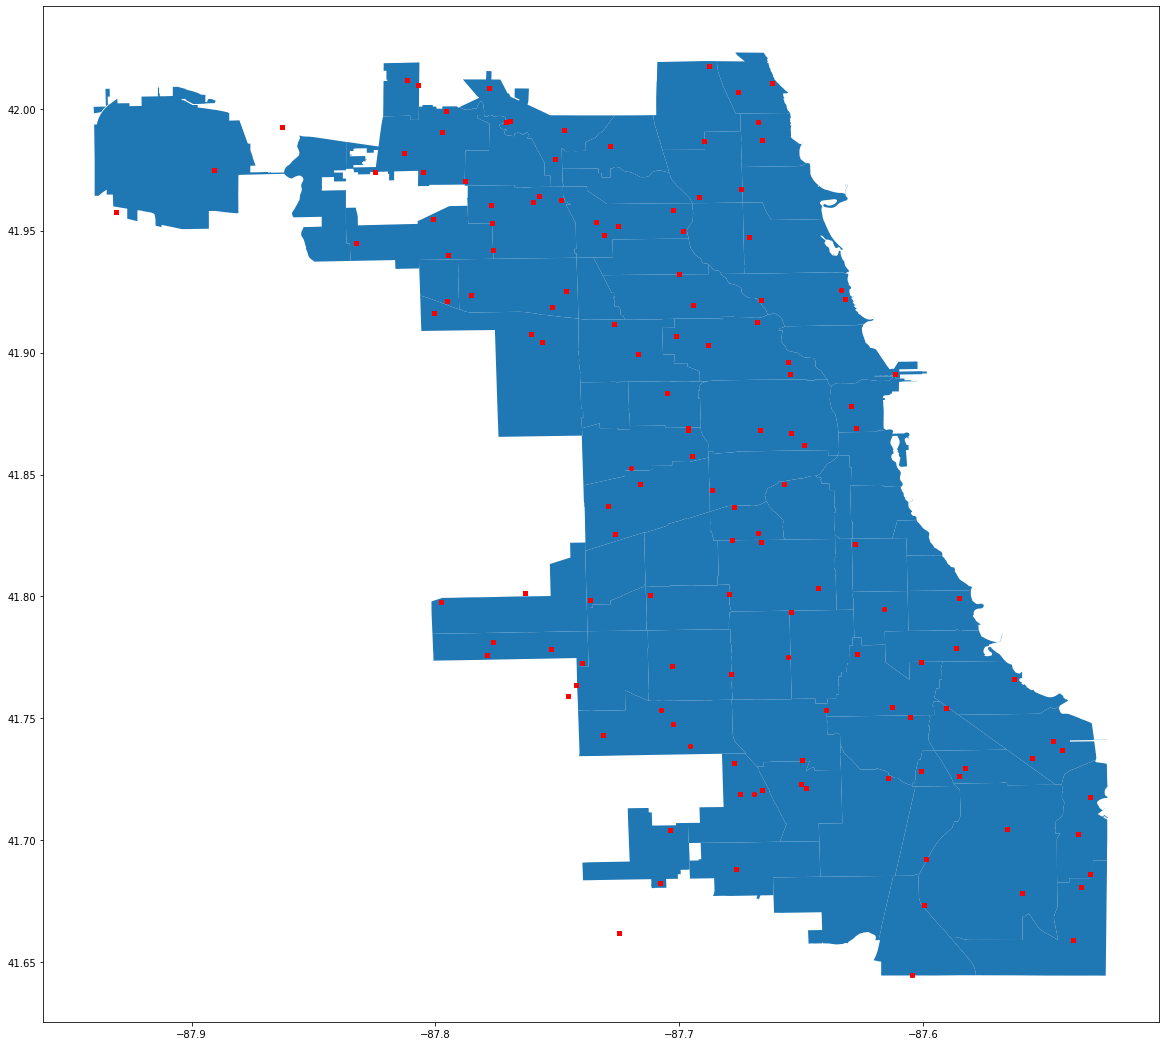

In [276]:
ax5=neighborhoods.plot(figsize=(20,20))
gdf_train.plot(ax=ax5, color='red', markersize=14,zorder=2, label='train data')

plt.show()

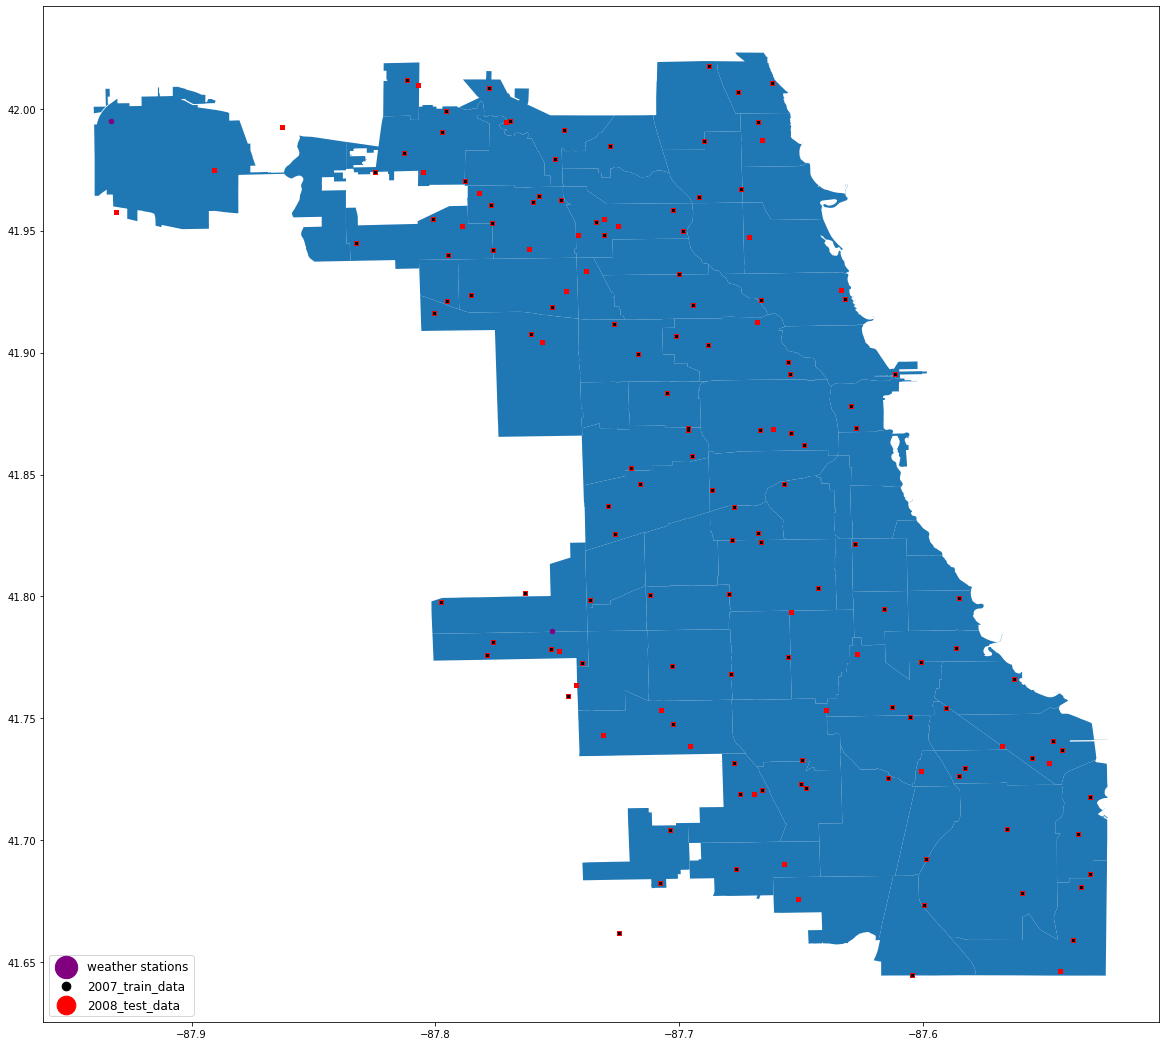

In [277]:
dict_df = {'2007_train_data' : df_train.query("Date.dt.year == 2007"), 
           '2008_test_data': df_test.query("Date.dt.year == 2008")
          }
plot_geodata(dict_df)

# split data based on year 

In [278]:
df_train.groupby(pd.Grouper(key="Date", freq="1M")).sum()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,
2007-05-31,906,"1,046.92","-2,192.40",198,40,0
2007-06-30,6785,"7,372.24","-15,438.18",1445,428,0
2007-07-31,20375,"24,054.62","-50,416.80",4355,7199,6
2007-08-31,70357,"85,680.15","-179,697.72",14984,40015,200
2007-09-30,27669,"32,362.34","-67,855.83",5786,9300,28
2007-10-31,8331,"8,827.50","-18,501.72",1665,1706,2
2007-11-30,0,0.00,0.00,0,0,0
2007-12-31,0,0.00,0.00,0,0,0
2008-01-31,0,0.00,0.00,0,0,0


In [279]:
df_train_2007 = df_train.query("Date.dt.year==2007")
#df_train_2008 = df_train.query("Date.dt.year==2008")
df_train_2009 = df_train.query("Date.dt.year==2009")
#df_train_2010 = df_train.query("Date.dt.year==2010")
df_train_2011 = df_train.query("Date.dt.year==2011")
#df_train_2012 = df_train.query("Date.dt.year==2012")
df_train_2013 = df_train.query("Date.dt.year==2013")

In [280]:
df_test.groupby(pd.Grouper(key="Date", freq="1M")).sum()

,Id,Block,Latitude,Longitude,AddressAccuracy
Date,,,,,
2008-06-30,6601161,149868,"152,035.88","-318,586.88",28878
2008-07-31,99519435,450296,"457,614.59","-958,921.01",86919
2008-08-31,161759635,352488,"358,979.72","-752,233.19",68210
2008-09-30,197199020,302917,"307,679.58","-644,723.12",58484
2008-10-31,0,0,0.00,0.00,0
2008-11-30,0,0,0.00,0.00,0
2008-12-31,0,0,0.00,0.00,0
2009-01-31,0,0,0.00,0.00,0
2009-02-28,0,0,0.00,0.00,0


In [281]:
df_test_2008 = df_test.query("Date.dt.year==2008")
df_test_2010 = df_test.query("Date.dt.year==2010")
df_test_2012 = df_test.query("Date.dt.year==2012")
df_test_2014 = df_test.query("Date.dt.year==2014")

In [282]:
df_spray.groupby(pd.Grouper(key="Date", freq="1M")).sum()

,Latitude,Longitude
Date,,
2011-09-30,"88,752.79","-185,621.73"
2011-10-31,0.00,0.00
2011-11-30,0.00,0.00
2011-12-31,0.00,0.00
2012-01-31,0.00,0.00
2012-02-29,0.00,0.00
2012-03-31,0.00,0.00
2012-04-30,0.00,0.00
2012-05-31,0.00,0.00


In [283]:
df_spray_2011 = df_spray.query("Date.dt.year==2011")
df_spray_2013 = df_spray.query("Date.dt.year==2013")

In [284]:
df_train_2007.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,geometry
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0,POINT (-87.80099 41.95469)
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0,POINT (-87.80099 41.95469)
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.99,-87.77,9,1,0,POINT (-87.76928 41.99499)
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,1,0,POINT (-87.82481 41.97409)
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,4,0,POINT (-87.82481 41.97409)


In [285]:
df_train_2007.groupby(pd.Grouper(key="Date", freq="1D")).sum()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,
2007-05-29,906,"1,046.92","-2,192.40",198,40,0
2007-05-30,0,0.00,0.00,0,0,0
2007-05-31,0,0.00,0.00,0,0,0
2007-06-01,0,0.00,0.00,0,0,0
2007-06-02,0,0.00,0.00,0,0,0
2007-06-03,0,0.00,0.00,0,0,0
2007-06-04,0,0.00,0.00,0,0,0
2007-06-05,2217,"2,512.95","-5,262.97",492,127,0
2007-06-06,0,0.00,0.00,0,0,0


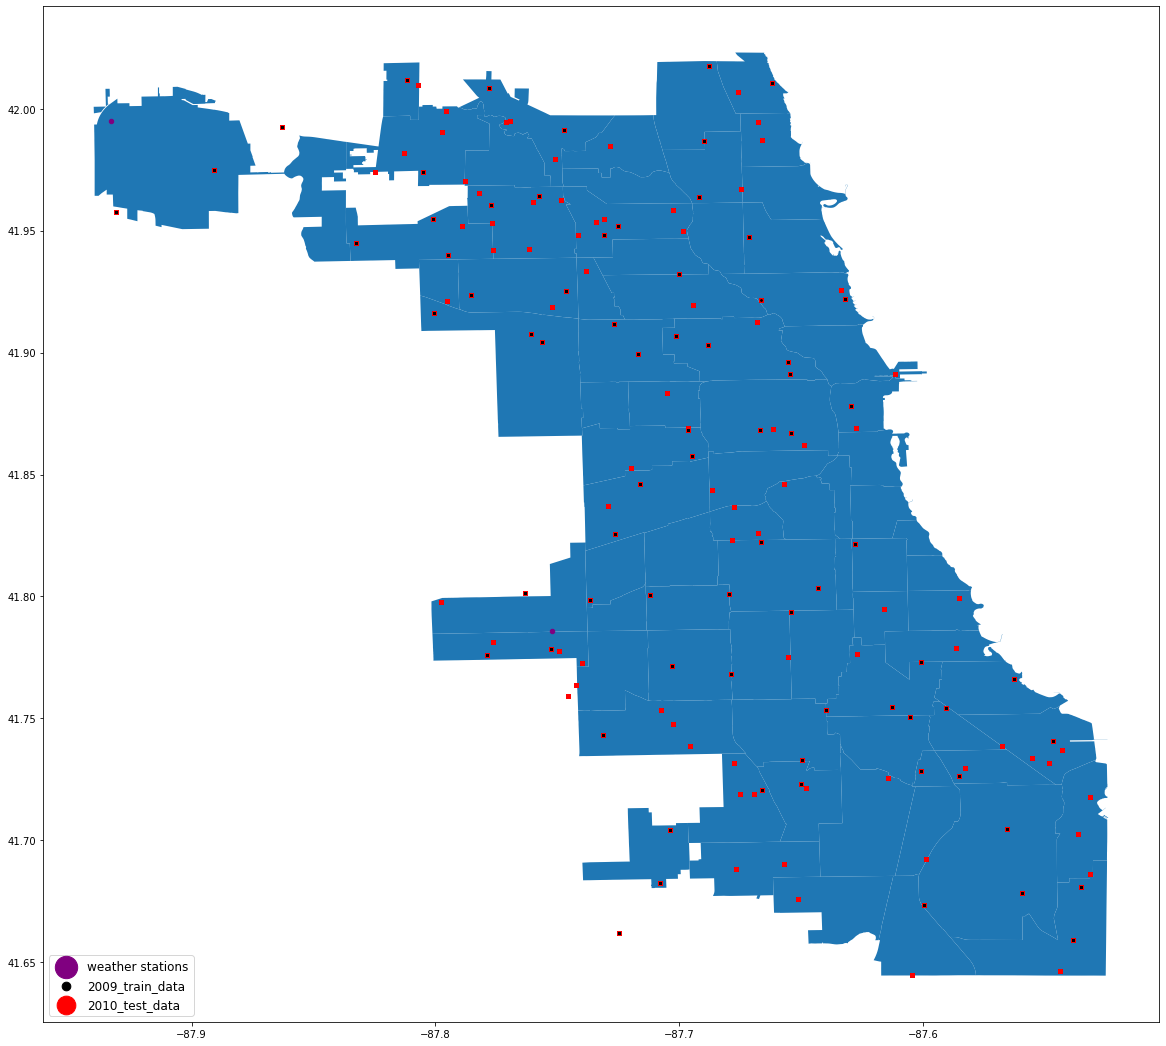

In [286]:
dict_df = {'2009_train_data' : df_train_2009, 
           '2010_test_data': df_test_2010
          }
plot_geodata(dict_df)

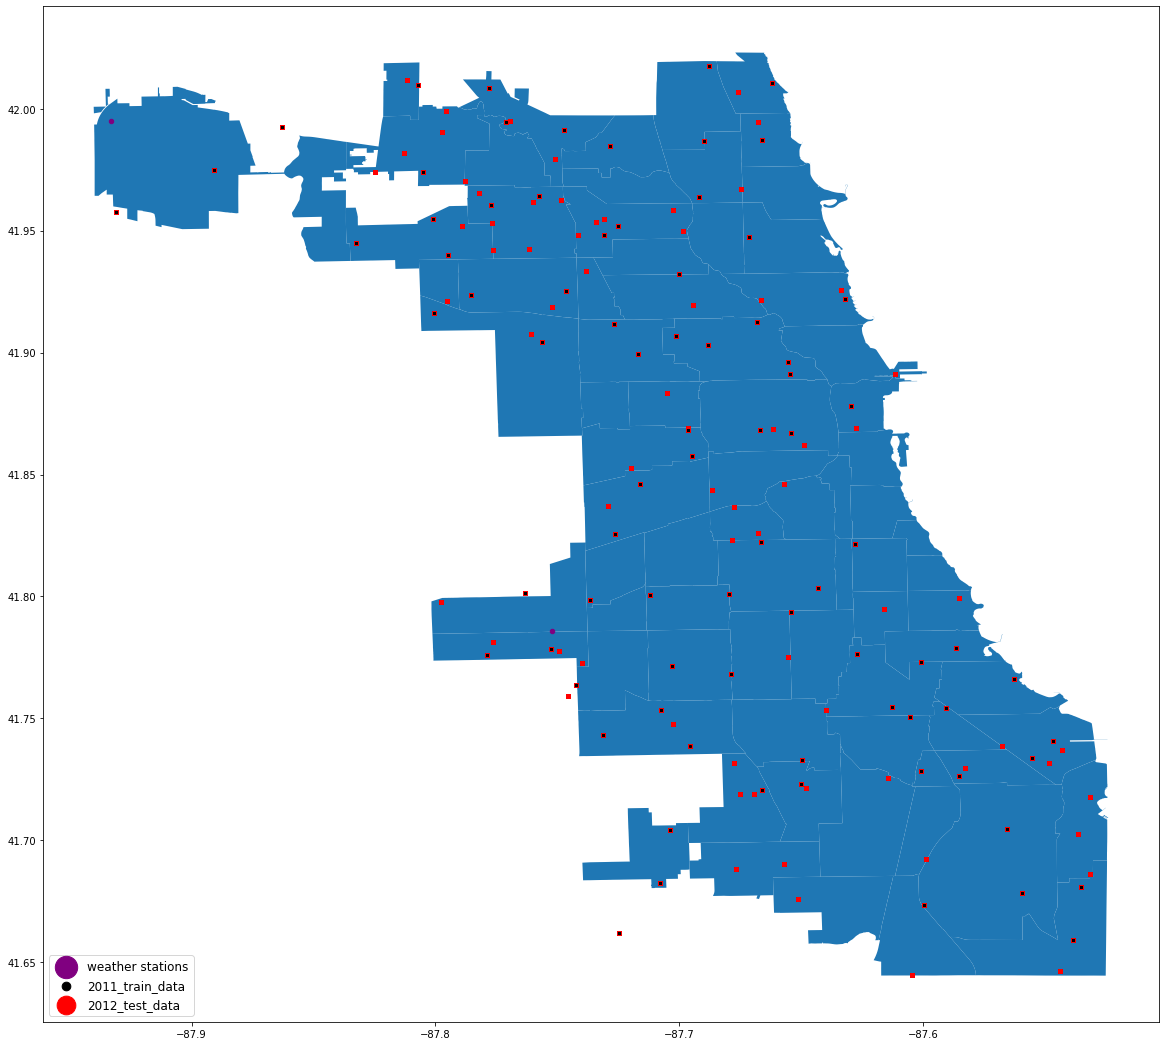

In [287]:
dict_df = {'2011_train_data' : df_train_2011, 
           '2012_test_data': df_test_2012
          }
plot_geodata(dict_df)

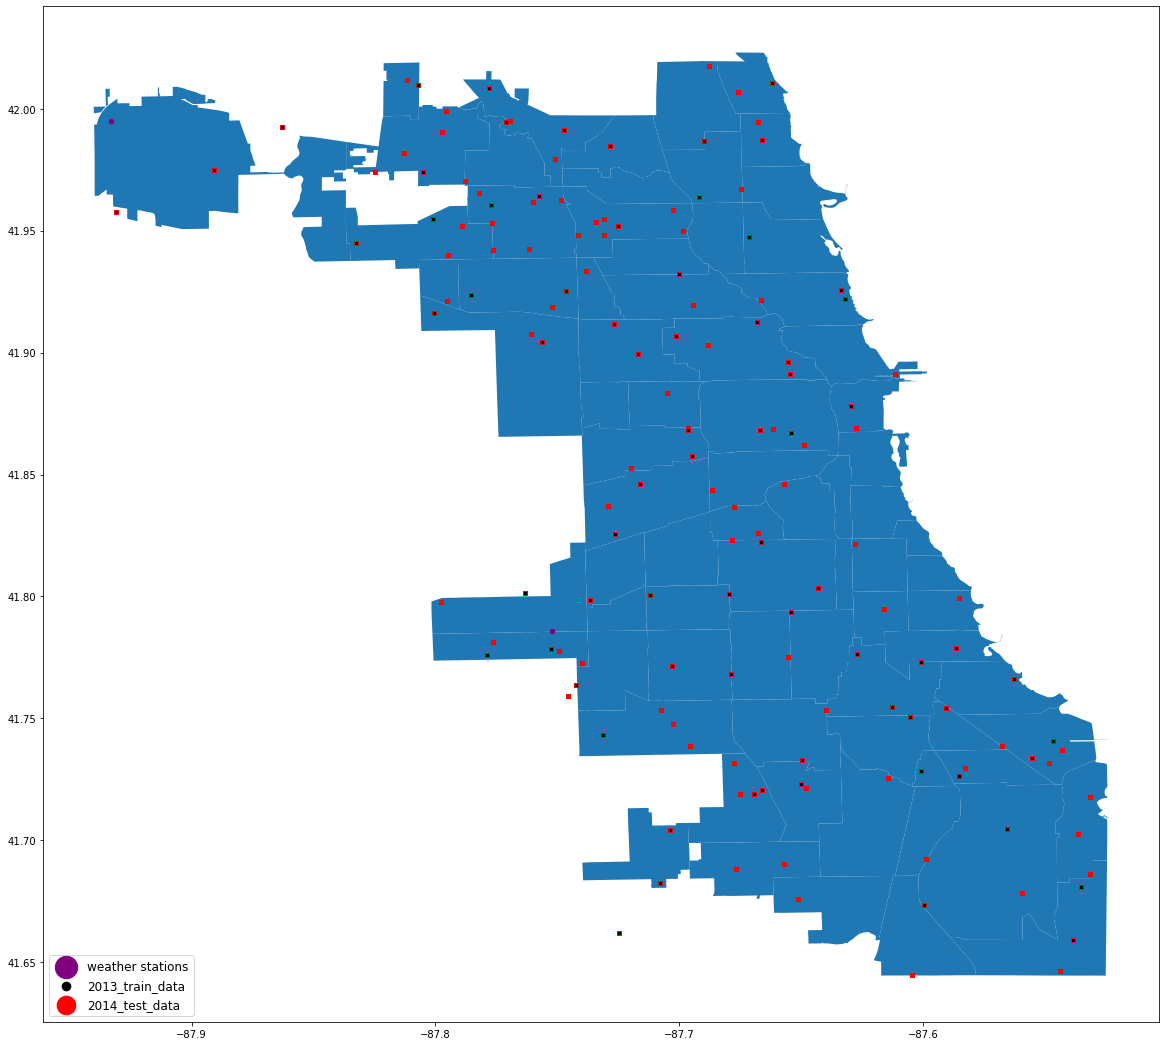

In [288]:
dict_df = {'2013_train_data' : df_train_2013, 
           '2014_test_data': df_test_2014
          }
plot_geodata(dict_df)

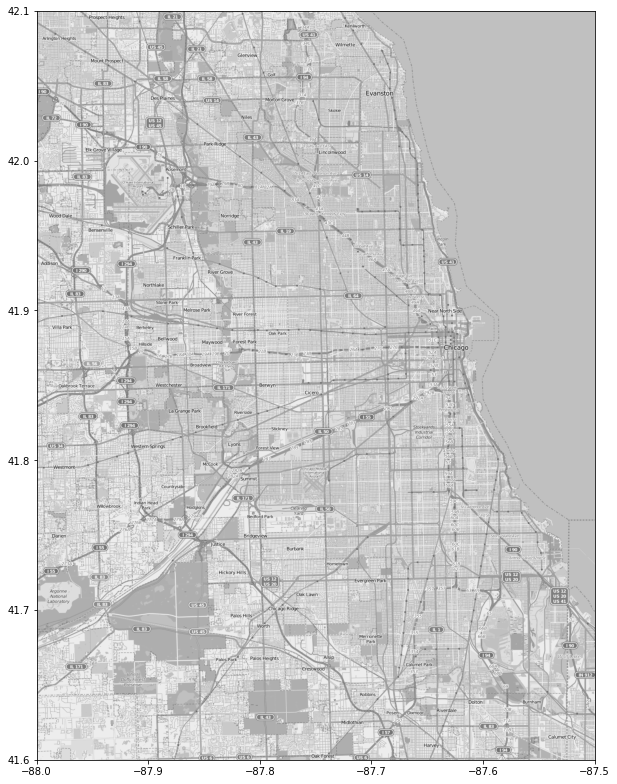

In [290]:
mapdata = np.loadtxt("../input/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)
plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)
plt.show()